In [1]:
%load_ext autoreload
%autoreload 2

from typing import Any
import random
import os

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from validation_model import ValidationModel
from settings import *
from notebooks.avapix_model import AvapixModel
from avapix_utils import ProcessorV1_1, ProcessorV1_0
import utils

In [2]:
DEVICE = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print (f'Using device: {DEVICE}')

Using device: cuda


In [68]:
class AvapixLoss(nn.Module):
    def __init__(self, zero_limit_value: float = 0.01) -> None:
        super().__init__()

        self.zero_limit_value = zero_limit_value

    def __face_shape_loss(self, x: torch.Tensor):
        """
        Given the validity of the generated image, calculate the
        loss of the generated image. The loss is calculated by
        the following formula:

        loss = tan(1) / x - tan(x)

        Which starts from 0 when x = 0, and increases exponentially
        as x approaches 1. Therefore the zero_limit_value, limits
        the minimum value of x to be zero_limit_value.

        The total loss is calculated by taking the mean of the
        cubed loss of each generated image.
        """
        x = x.masked_fill(x < self.zero_limit_value, self.zero_limit_value)

        one_tensor = torch.tensor([1.0], device=self.device)
        loss = torch.tan(one_tensor) / x - torch.tan(x)
        loss = loss.pow(2).mean()

        return loss

    def __penalty_loss(self, output_img: torch.Tensor, org_img: torch.Tensor):
        """
        Penalize the output image embedded color images are not the same
        as the original image.
        """
        mask = org_img != 0

        result = torch.zeros_like(output_img)
        result[mask] = output_img[mask]

        loss = ((result - org_img) * 255).pow(2).mean()

        return loss

    def forward(self, x: torch.Tensor, output_img: torch.Tensor, org_img: torch.Tensor):
        self.device = x.device

        loss = self.__face_shape_loss(x)
        loss += self.__penalty_loss(output_img, org_img)

        return loss.requires_grad_(True)


In [64]:
class EmbeddedFacesDataset(Dataset):
    def __init__(self, num_samples, device) -> None:
        super().__init__()

        self.num_samples = num_samples
        self.device = device
        self.random_lengths = list(range(128))
        self.processor = ProcessorV1_1()
        self.chars = " !\"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"

    def __getitem__(self, _) -> Any:
        curr_rand_len = random.choice(self.random_lengths)

        choices = np.random.choice(list(self.chars), curr_rand_len)
        text = ''.join(choices)

        output_img = self.processor.embed(text)
        output_img = utils.numpy_to_tensor(output_img, self.device)

        return output_img

    def __len__(self):
        return self.num_samples


In [69]:
LEARNING_RATE = 0.00005
BATCH_SIZE = 16

total_epochs = 0

ds = EmbeddedFacesDataset(10_000, DEVICE)
dl = DataLoader(ds, BATCH_SIZE)

model = AvapixModel()
model.to(DEVICE)

criterion = AvapixLoss(1e-6)

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load("./checkpoints_vm/epoch-50.pth"))
loss_model.to(DEVICE)
loss_model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
losses = []

In [70]:
for epoch in range(50):
    model.train()
    total_loss = 0.0

    for batch_imgs in dl:
        optimizer.zero_grad()
        outputs = model(batch_imgs)

        face_loss = loss_model(outputs)
        loss = criterion(face_loss, outputs, batch_imgs)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dl)
    losses.append(avg_loss)

    print(f"Epoch {total_epochs + 1:02d} - Loss: {avg_loss:,.4f}", end="\t\t")
    if (total_epochs + 1) % 2 == 0:
        print()

    # save progress
    #   save checkpoint
    torch.save(model.state_dict(), f"./checkpoints_am/epoch-{total_epochs + 1}.pth")
    #   save model output
    img = utils.tensor_to_numpy(outputs[0])
    Image.fromarray(np.kron(img, np.ones((30, 30, 1))).astype(np.uint8)).save(
        f"./train_outputs/{total_epochs + 1:02d}.png"
    )

    total_epochs += 1

print("Training complete.")

Epoch 01 - Loss: 891.8587		Epoch 02 - Loss: 503.3974		
Epoch 03 - Loss: 405.3815		Epoch 04 - Loss: 353.1670		
Epoch 05 - Loss: 323.9559		Epoch 06 - Loss: 314.5663		
Epoch 07 - Loss: 303.0866		Epoch 08 - Loss: 298.4567		
Epoch 09 - Loss: 290.3549		Epoch 10 - Loss: 288.6297		
Epoch 11 - Loss: 282.7677		Epoch 12 - Loss: 279.3332		
Epoch 13 - Loss: 282.3686		Epoch 14 - Loss: 274.3497		
Epoch 15 - Loss: 270.9303		Epoch 16 - Loss: 267.5526		
Epoch 17 - Loss: 266.4119		Epoch 18 - Loss: 265.4791		
Epoch 19 - Loss: 260.6498		Epoch 20 - Loss: 260.5195		
Epoch 21 - Loss: 255.7344		Epoch 22 - Loss: 253.1896		
Epoch 23 - Loss: 250.2279		Epoch 24 - Loss: 247.7959		
Epoch 25 - Loss: 246.9564		Epoch 26 - Loss: 245.8108		
Epoch 27 - Loss: 245.6559		Epoch 28 - Loss: 242.0671		
Epoch 29 - Loss: 241.2047		Epoch 30 - Loss: 237.9550		
Epoch 31 - Loss: 237.6712		Epoch 32 - Loss: 236.5747		
Epoch 33 - Loss: 237.7643		Epoch 34 - Loss: 233.5632		
Epoch 35 - Loss: 232.7610		Epoch 36 - Loss: 232.2559		
Epoch 37 -

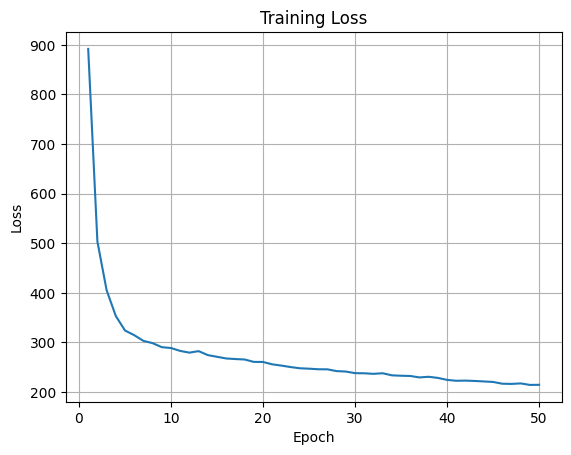

In [71]:
plt.plot(range(1, total_epochs + 1), losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Test Area
---

In [72]:
processor = ProcessorV1_1()
embedded_img = processor.embed('bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh')
input_img = utils.numpy_to_tensor(embedded_img, DEVICE).unsqueeze(0)

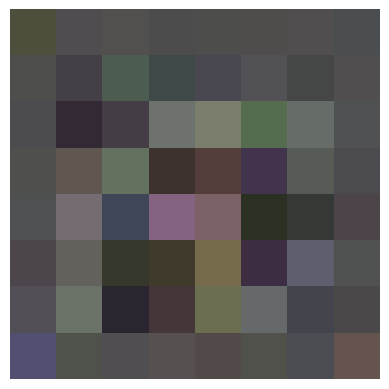

In [73]:
model.eval()
output_img = model(input_img)
utils.show_model_output_image(output_img)

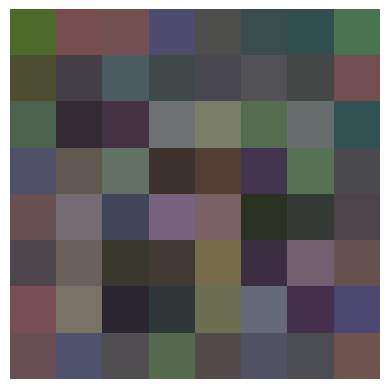

In [74]:
mask = input_img != 0
output_img[mask] = input_img[mask]

utils.show_model_output_image(output_img)

In [62]:
processor.extract(output_img.detach().cpu().squeeze().permute(1, 2, 0).mul(255).numpy().astype(np.uint8))

'bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh\r \x18\x00\x07þ\x12\x00\x00\x00\x01\x02\x00<\x05\x00\x01\x0b\x00\x04\x04\x00\x00\x01\x04\x04\x00\x00\x00\x00\x08\x00\x00\x02\x04\x01\x00\x00\x00\x01\x01\x01\x00\x01\x02\x11\x02\x00\x00\x08\n\x03\x02\x04\x10\x00\x00\x00\x05\x00\x00\x04\x00\x00\x00\x010\x01\x06\x14\x13\x0b'

In [34]:
torch.save(model.state_dict(), "./avapix_in_progress.pth")